# PROPHET MODELS 1

In this notebook, we are going to fit Prophet models by using the dataset without COVID data.

Prophet is an open source software developed by Facebook, now Meta, in 2017 by Sean J. Taylor and Ben Lethan that implements a forecasting procedure that takes into account non-linear trends with multiple seasonal periods, such as annual, monthly, weekly and daily.

Prophet consists of an additive model in which each time series is modeled as the combination of a trend component, a seasonal component, holiday effects and an error term, which is normally distributed. Mathematically, this can be expressed as:

$$ y(t) = g(t) + s(t) + h(t) + e_t,$$

where: 

* $g(t)$ is the trend component.
* $s(t)$ is the seasonal component.
* $h(t)$ represents the effects of holidays.
* $e_t$ is the error term, which represents changes that the model cannot explain.

### Trend component
There are two types of trend components.

1. **Linear Trend**: $g(t) = (k + a(t)^T \delta)t + (m + a(t)^T \gamma),$

where: 
* $k$ is the growth rate.
* $\delta$ is the adjusted rate.
* $m$ is the decompensation parameter.

2. **Nonlinear, Saturating Growth Trend**: $g(t) = \frac{C}{1 + exp(-k(t-m))},$

where:
* $C$ is the maximum saturation level.
* $k$ is the growth rate. 
* $m$ is a compensation parameter.

### Seasonal component

$$
\sum_{n=1}^{N} \left(a_n cos\left(\frac{2 \pi i n}{P}\right) + b_n sin\left(\frac{2 \pi i n}{P}\right)\right),
$$

where:

* $P$ is the length of the seasonal period in days.
* $N$ is the number of terms in the Fourier series.

### Holidays effects

We incorporate a list with the holidays in the model, assuming their effects are independent.

### 📑 Index
* [1. FIRST PROPHET MODEL](#first_model)
* [2. PROPHET MODEL WITH BEST PARAMETERS](#crossval)

Import the packages.

In [ ]:
import numpy as np
import pandas as pd
import itertools
from sklearn import metrics

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics


import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("fbprophet").setLevel(logging.WARNING)

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
dark_style = {
    "figure.facecolor": "#212946",
    "axes.facecolor": "#212946",
    "savefig.facecolor": "#212946",
    "axes.grid": True,
    "axes.grid.which": "both",
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "grid.color": "#2A3459",
    "grid.linewidth": "1",
    "text.color": "0.6",
    "axes.labelcolor": "0.6",
    "xtick.color": "0.6",
    "ytick.color": "0.6",
    "font.size": 12,
}
plt.rcParams.update(dark_style)
rcParams["figure.figsize"] = (18, 7)

Load the data and consider that our data set goes from 2003 to 2019 (without COVID).

In [2]:
df = pd.read_csv(
    "C:/Users/Juanfran cd/Desktop/MATEMATICAS UA/TFG/air traffic.csv",
    encoding="ISO-8859-1",
)

# Clean and convert 'Pax' to number
df["Pax"] = df["Pax"].str.replace(",", "", regex=True).astype(float)

# Create date column in YYYY-MM format
df["Date"] = pd.to_datetime(
    df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2), format="%Y-%m"
)

# Filter data between 2003 and 2019 and select relevant columns
df1 = df.loc[df["Year"].between(2003, 2019), ["Date", "Pax"]].copy()

Split the data set into 2: a training set (from 2003 to 2017, that is 180 values) and a test set (from 2018 to 2019, that is 24 values).

In [3]:
train = df1.loc[df1["Date"] <= "2017-12-01"]
test = df1.loc[df1["Date"] >= "2018-01-01"]

Plot of Training-Test split

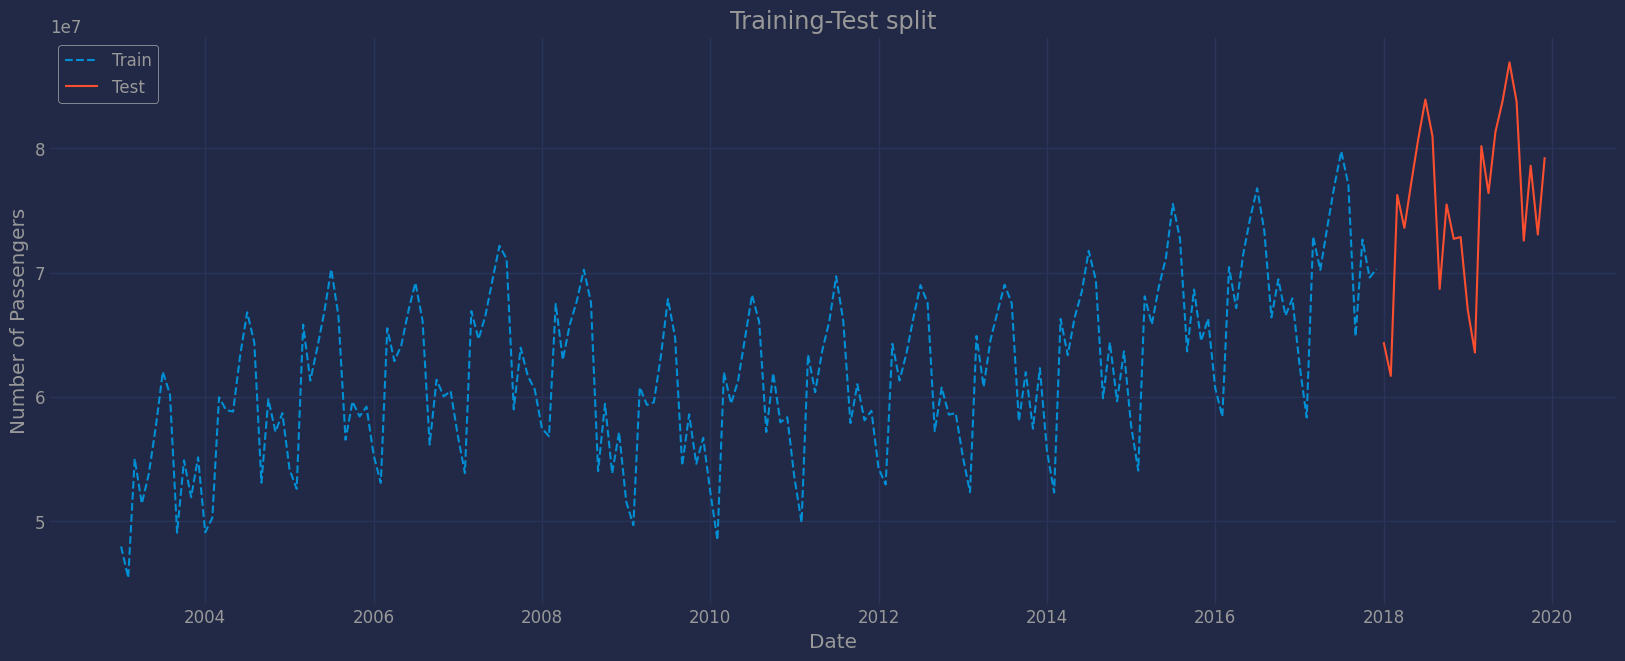

In [4]:
sns.lineplot(data=train, x="Date", y="Pax", label="Train", linestyle="--")
sns.lineplot(data=test, x="Date", y="Pax", label="Test")
plt.title("Training-Test split")
plt.ylabel("Number of Passengers")
plt.show()

<a id='first_model'></a>
## 1. FIRST PROPHET MODEL

Prophet expects the data to be formatted in a specific way. The model expects a column *ds* containing the dates and a column *y* containing the values we want to model/forecast.

In [5]:
train = train.rename(columns={"Date": "ds", "Pax": "y"})
test = test.rename(columns={"Date": "ds", "Pax": "y"})

In [6]:
model = Prophet()

# Train the model
model.fit(train)

# Generate 24 months (2 years) of future data
future = model.make_future_dataframe(periods=24, freq="ME")
future["ds"] = future["ds"] + pd.offsets.MonthBegin()

# Forecasting
forecast = model.predict(future)
train[["yhat1", "yhat1_lower", "yhat1_upper"]] = (
    forecast[["yhat", "yhat_lower", "yhat_upper"]].iloc[:180].values
)
test.loc[:, ["yhat1", "yhat1_lower", "yhat1_upper"]] = (
    forecast[["yhat", "yhat_lower", "yhat_upper"]].iloc[-24:].values
)

14:14:43 - cmdstanpy - INFO - Chain [1] start processing
14:14:44 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-02-01,5.296716e+07,4.242703e+07,4.525823e+07,5.296716e+07,5.296716e+07,-9.110568e+06,-9.110568e+06,-9.110568e+06,-9.110568e+06,-9.110568e+06,-9.110568e+06,0.0,0.0,0.0,4.385660e+07
1,2003-03-01,5.326461e+07,5.440311e+07,5.703129e+07,5.326461e+07,5.326461e+07,2.412702e+06,2.412702e+06,2.412702e+06,2.412702e+06,2.412702e+06,2.412702e+06,0.0,0.0,0.0,5.567731e+07
2,2003-04-01,5.359392e+07,5.188498e+07,5.466735e+07,5.359392e+07,5.359392e+07,-3.093819e+05,-3.093819e+05,-3.093819e+05,-3.093819e+05,-3.093819e+05,-3.093819e+05,0.0,0.0,0.0,5.328454e+07
3,2003-05-01,5.391261e+07,5.466341e+07,5.748119e+07,5.391261e+07,5.391261e+07,2.161863e+06,2.161863e+06,2.161863e+06,2.161863e+06,2.161863e+06,2.161863e+06,0.0,0.0,0.0,5.607447e+07
4,2003-06-01,5.424192e+07,5.770715e+07,6.053649e+07,5.424192e+07,5.424192e+07,4.854293e+06,4.854293e+06,4.854293e+06,4.854293e+06,4.854293e+06,4.854293e+06,0.0,0.0,0.0,5.909621e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,7.625042e+07,7.985025e+07,8.358692e+07,7.498878e+07,7.751556e+07,5.546130e+06,5.546130e+06,5.546130e+06,5.546130e+06,5.546130e+06,5.546130e+06,0.0,0.0,0.0,8.179654e+07
200,2019-09-01,7.645363e+07,6.983198e+07,7.383257e+07,7.510513e+07,7.781436e+07,-4.694034e+06,-4.694034e+06,-4.694034e+06,-4.694034e+06,-4.694034e+06,-4.694034e+06,0.0,0.0,0.0,7.175960e+07
201,2019-10-01,7.665030e+07,7.441196e+07,7.851716e+07,7.523194e+07,7.811934e+07,-2.493052e+05,-2.493052e+05,-2.493052e+05,-2.493052e+05,-2.493052e+05,-2.493052e+05,0.0,0.0,0.0,7.640099e+07
202,2019-11-01,7.685352e+07,7.109316e+07,7.540297e+07,7.537095e+07,7.843656e+07,-3.602341e+06,-3.602341e+06,-3.602341e+06,-3.602341e+06,-3.602341e+06,-3.602341e+06,0.0,0.0,0.0,7.325118e+07


Plot of Prophet Forecast

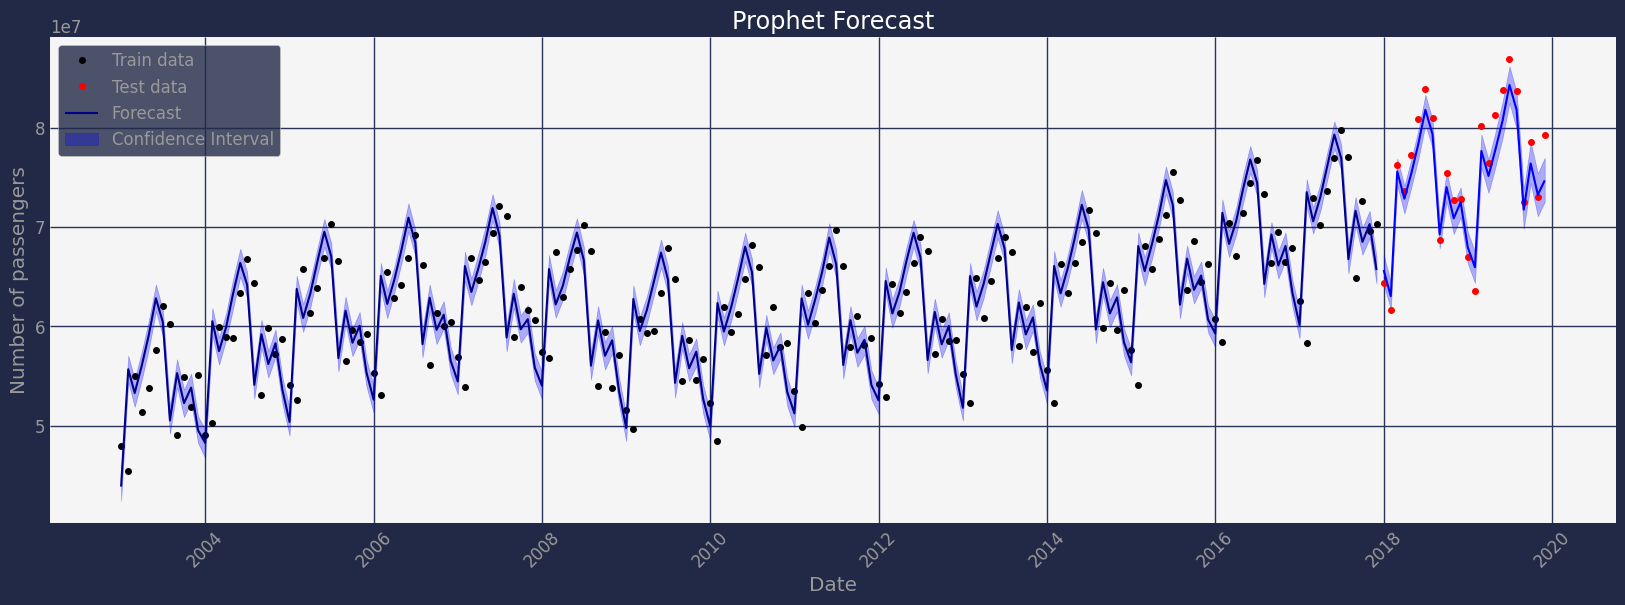

In [8]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(train["ds"], train["y"], "o", label="Train data", color="black", markersize=4)
ax.plot(test["ds"], test["y"], "o", label="Test data", color="red", markersize=4)

ax.plot(train["ds"], train["yhat1"], label="Forecast", color="darkblue")
ax.plot(test["ds"], test["yhat1"], color="blue")
ax.fill_between(
    train["ds"], train["yhat1_lower"], train["yhat1_upper"], color="blue", alpha=0.3
)
ax.fill_between(
    test["ds"],
    test["yhat1_lower"],
    test["yhat1_upper"],
    color="blue",
    alpha=0.3,
    label="Confidence Interval",
)

ax.set_facecolor("whitesmoke")
ax.legend(loc="upper left")
plt.title("Prophet Forecast", color="white")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.xticks(rotation=45)

plt.savefig(
    "../graphics/Prophet_sin_covid/forecast_plot.png", dpi=300, bbox_inches="tight"
)
plt.show()

Prediction components

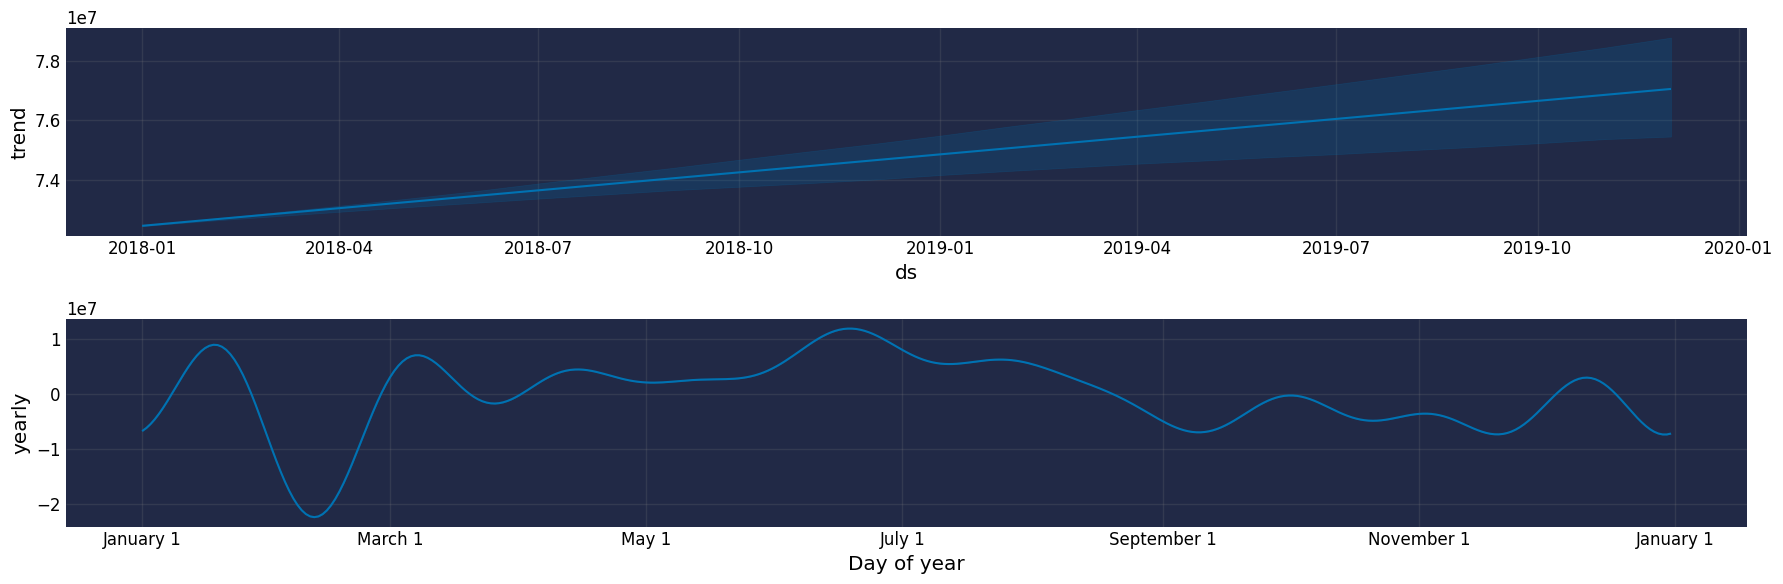

In [9]:
fig = model.plot_components(forecast.tail(24), figsize=(18, 6))

for ax in fig.axes:
    ax.title.set_color("black")
    ax.xaxis.label.set_color("black")
    ax.yaxis.label.set_color("black")
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")

plt.show()

Prediction on test set

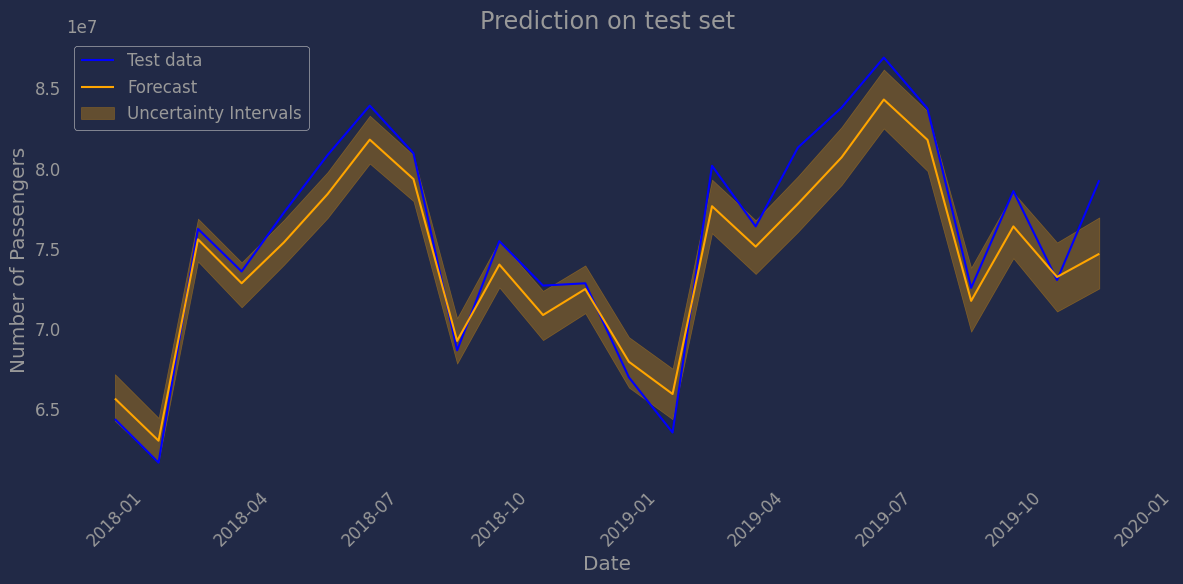

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(test["ds"], test["y"], label="Test data", color="blue")
plt.plot(test["ds"], test["yhat1"], label="Forecast", color="orange")

plt.fill_between(
    test["ds"],
    test["yhat1_lower"],
    test["yhat1_upper"],
    color="orange",
    alpha=0.3,
    label="Uncertainty Intervals",
)

ax = plt.gca()
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.title("Prediction on test set")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig(
    "../graphics/Prophet_sin_covid/predictions_on_test_set.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

#### Error Metrics

In [11]:
def EVAL_METRICS_FUNC(y_true, y_pred):
    def MAPE(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print("Metric evaluation result:-")
    print(f"MAE: {metrics.mean_absolute_error(y_true, y_pred)}")
    print(f"MAPE: {MAPE(y_true, y_pred)}")

For train set

In [12]:
y_true = train["y"].values
y_pred = train["yhat1"].values
print(EVAL_METRICS_FUNC(y_true, y_pred))

Metric evaluation result:-
MAE: 4446712.077079841
MAPE: 7.395334290616855
None


For test set

In [13]:
y_true = test["y"].values
y_pred = test["yhat1"].values
print(EVAL_METRICS_FUNC(y_true, y_pred))

Metric evaluation result:-
MAE: 1767450.8570903728
MAPE: 2.2973126805162876
None


We can see that there is no presence of overfiting, since there is not great changes between the metrics for train set and the metrics for test set.

<a id='crossval'></a>
## 2. PROPHET MODEL WITH BEST PARAMETERS

Let's adjust the main parameters manually in the model.

#### *changepoints*

*changepoints* are the date points at which the time series has abrupt changes in the path. By default, Prophet adds 25 change points to the initial 80% of the dataset.

6     2003-07-01
11    2003-12-01
17    2004-06-01
23    2004-12-01
29    2005-06-01
34    2005-11-01
40    2006-05-01
46    2006-11-01
51    2007-04-01
57    2007-10-01
63    2008-04-01
69    2008-10-01
74    2009-03-01
80    2009-09-01
86    2010-03-01
92    2010-09-01
97    2011-02-01
103   2011-08-01
109   2012-02-01
114   2012-07-01
120   2013-01-01
126   2013-07-01
132   2014-01-01
137   2014-06-01
143   2014-12-01
Name: ds, dtype: datetime64[ns]

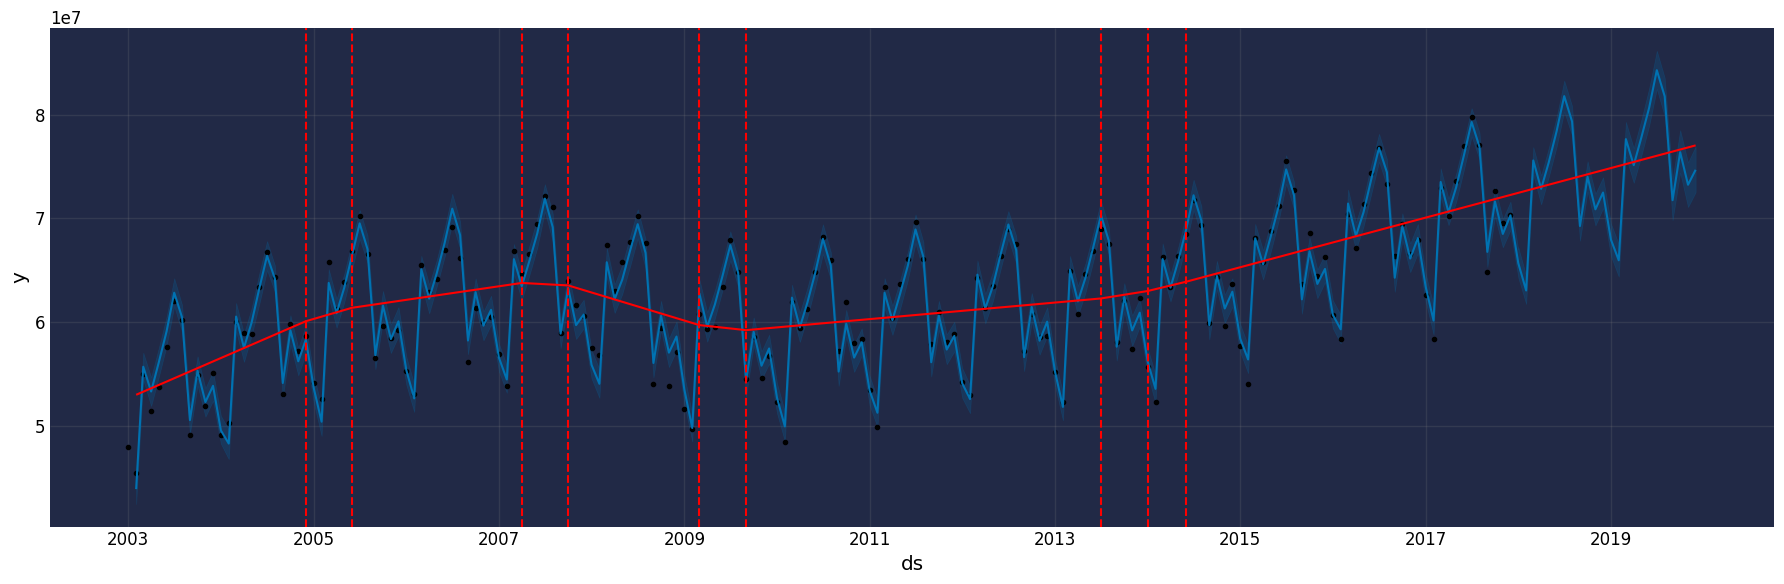

In [14]:
# Plot the prediction and add the detected change points. Draw vertical lines where the possible change points occurred.
fig = model.plot(forecast, figsize=(18, 6))
add_changepoints_to_plot(fig.gca(), model, forecast)
for ax in fig.axes:
    ax.title.set_color("black")
    ax.xaxis.label.set_color("black")
    ax.yaxis.label.set_color("black")
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")

# List of dates where Prophet detected changes in the trend
model.changepoints

If change points are specifically known, they can be added manually to the model.

In [15]:
changepoints = [
    "2004-12-01",
    "2005-06-01",
    "2007-04-01",
    "2007-10-01",
    "2009-03-01",
    "2009-09-01",
    "2013-07-01",
    "2014-01-01",
    "2014-06-01",
    "2016-01-01",
    "2017-06-01",
]

model1 = Prophet(changepoints=changepoints)

#### *changepoint_range*

*changepoint_range* is the initial data percentage for which the presence of change points is studied. By default, it is 80%.

14:14:48 - cmdstanpy - INFO - Chain [1] start processing
14:14:48 - cmdstanpy - INFO - Chain [1] done processing


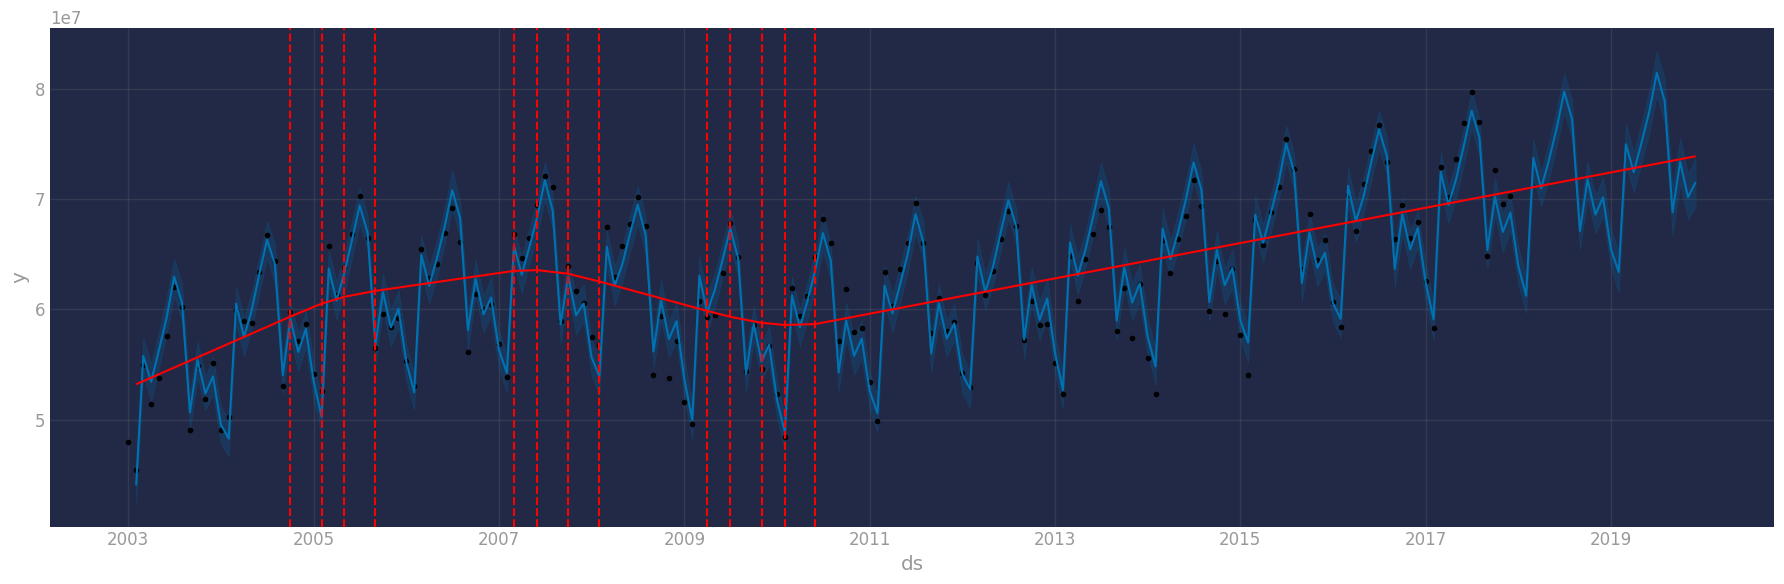

In [16]:
# Add 50% change points
model2 = Prophet(changepoint_range=0.5)
forecast2 = model2.fit(train).predict(future)
fig = model2.plot(forecast2, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), model2, forecast2)

#### *n_changepoints*

*n_changepoints* is the maximum number of change points that can be set.

14:14:49 - cmdstanpy - INFO - Chain [1] start processing
14:14:49 - cmdstanpy - INFO - Chain [1] done processing


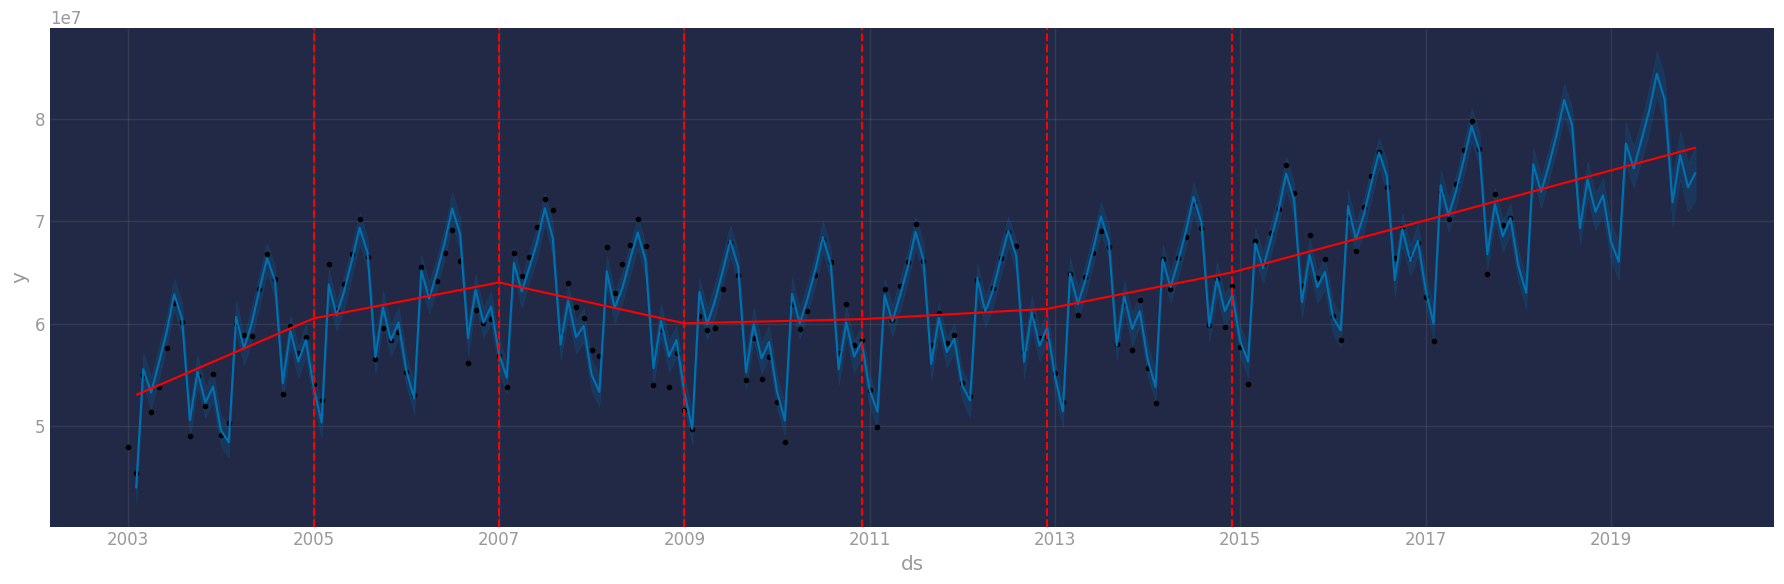

In [17]:
# 6 change points
model3 = Prophet(n_changepoints=6)
forecast3 = model3.fit(train).predict(future)
fig = model3.plot(forecast3, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), model3, forecast3)

#### *changepoint_prior_scale*

Prophet allows to adjust the trend to avoid overfitting or underfitting. *changepoint_prior_scale* helps to adjust this trend. The default value for *changepoint_prior_scale* is 0.05.

* It decreased to make the trend less flexible. A very low value can cause underfitting. 
* It increased to make the trend more flexible. A very high value can cause overfitting.

14:14:50 - cmdstanpy - INFO - Chain [1] start processing
14:14:50 - cmdstanpy - INFO - Chain [1] done processing


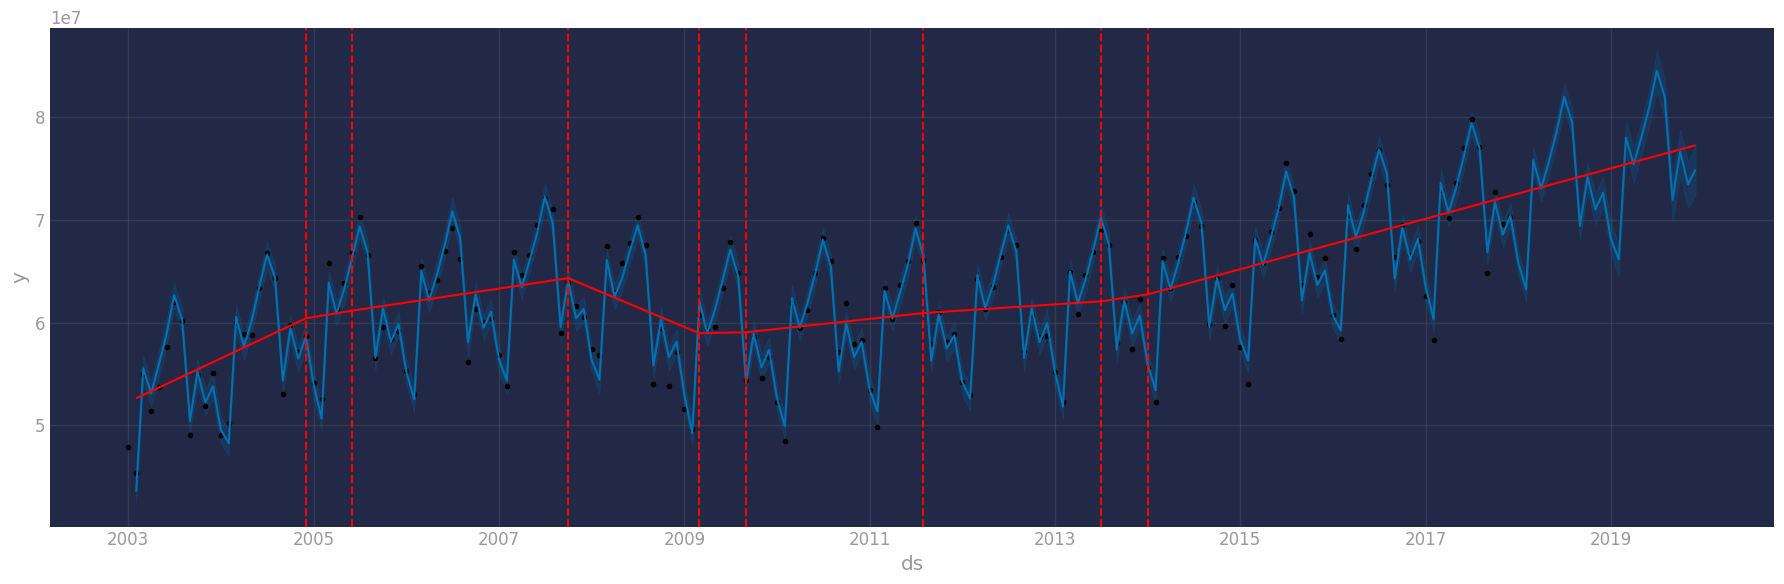

In [18]:
# A value of 0.05 for changepoint_prior_scale
model4 = Prophet(changepoint_prior_scale=0.08)
forecast4 = model4.fit(train).predict(future)
fig = model4.plot(forecast4, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), model4, forecast4)

#### *seasonality_prior_scale*

*seasonality_prior_scale* controls the seasonal component. By defaul, it is 10.

* A greater value allows the seasonality to be more flexible, which means that the model can fit more into seasonal patterns in the data. 
* A lower value restricts flexibility, which can result in a smoother model and less reactive to seasonal variations.

14:14:50 - cmdstanpy - INFO - Chain [1] start processing
14:14:51 - cmdstanpy - INFO - Chain [1] done processing


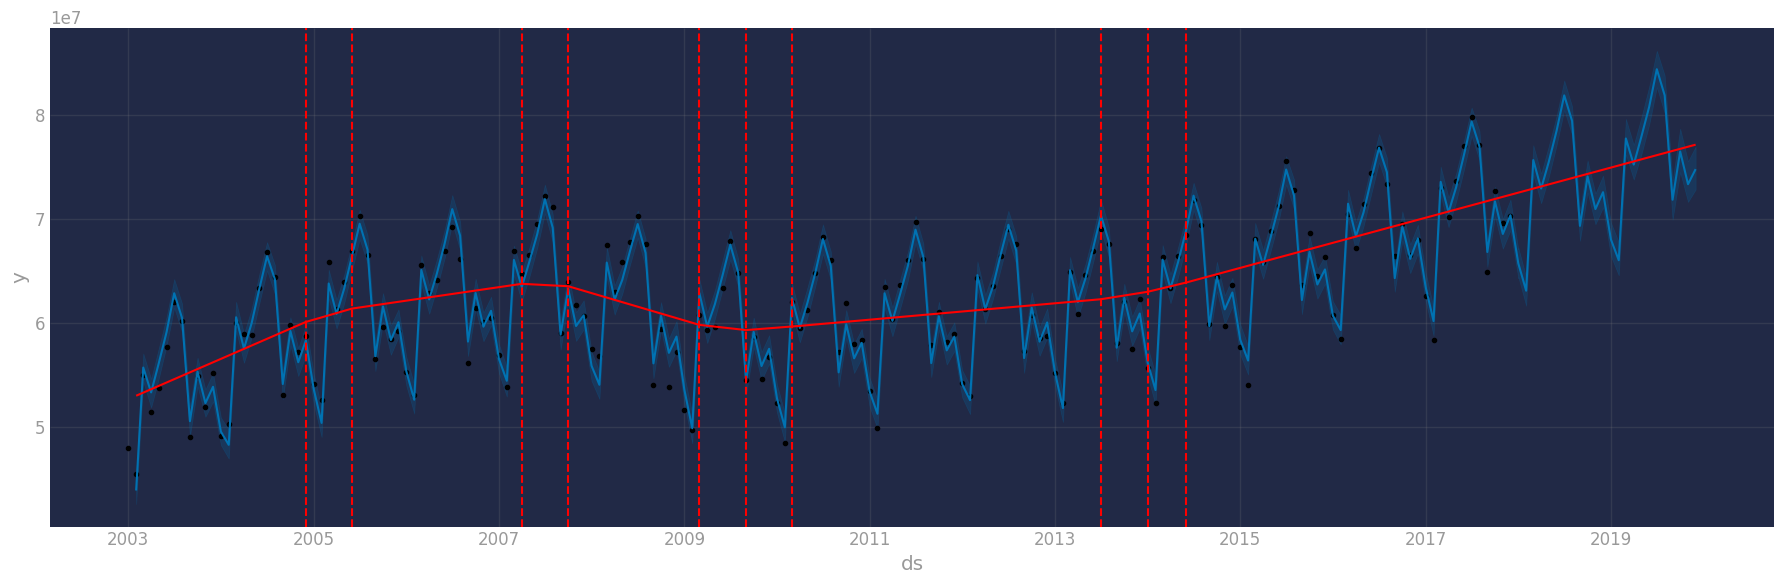

In [19]:
# A value of 5 for seasonality_prior_scale
model5 = Prophet(seasonality_prior_scale=5)
forecast5 = model5.fit(train).predict(future)
fig = model5.plot(forecast5, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), model5, forecast5)

#### *holidays_prior_scale*

*holidays_prior_scale* determines the flexibility of the holiday component. By defaul, it is 10.

* A higher value allows the model to better fit the effects of holidays.
* A lower value limits the influence of holidays on predictions.

14:14:51 - cmdstanpy - INFO - Chain [1] start processing
14:14:51 - cmdstanpy - INFO - Chain [1] done processing


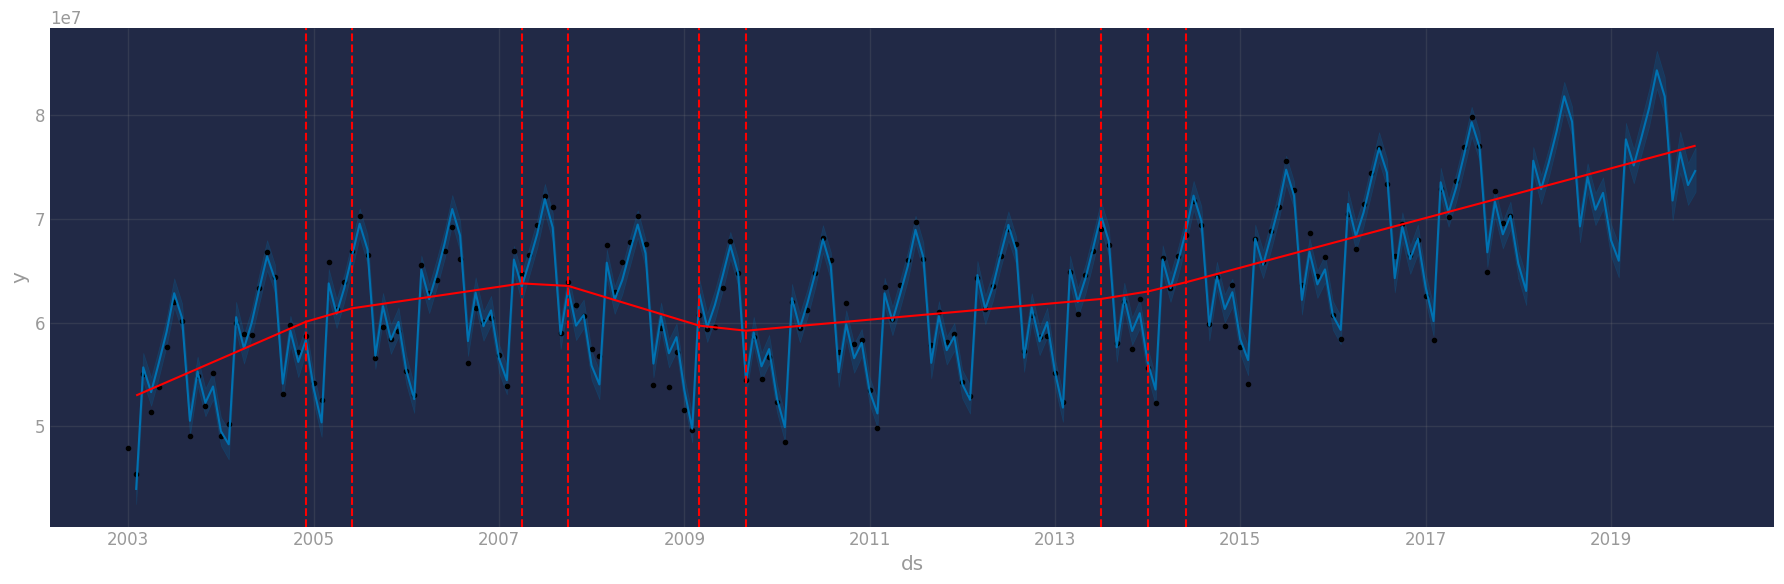

In [20]:
# A value of 5 for holidays_prior_scale
model6 = Prophet(holidays_prior_scale=5)
forecast6 = model6.fit(train).predict(future)
fig = model6.plot(forecast6, figsize=(18, 6))
a = add_changepoints_to_plot(fig.gca(), model6, forecast6)

Moreover, we can find the best parameters automatically from combinations and using cross-validation.

In [21]:
train["cap"] = 1.0e8  # For example, set a capacity of 100 million

In [ ]:
param_grid = {
    "changepoint_prior_scale": [0.005, 0.05, 0.5],
    "changepoint_range": [0.68, 0.8, 0.92],
    "seasonality_prior_scale": [0.05, 1.0],
    "holidays_prior_scale": [0.05, 1.0],
    "seasonality_mode": ["additive", "multiplicative"],
    "growth": ["linear", "logistic"],
    "yearly_seasonality": [5, 10, 20],
}

# Generate all possible combinations of parameters
all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]

# Evaluate each set of parameters in cross-validation
rmse_scores = []

for params in all_params:
    model = Prophet(**params)
    model.fit(train)

    # Cross-validation within the training set
    df_cv = cross_validation(
        model,
        horizon="730 days",
        period="365 days",
        initial="3650 days",
        disable_tqdm=True,
    )

    df_p = performance_metrics(df_cv, metrics=["rmse"])

    rmse_scores.append(df_p["rmse"].values[0])

best_parameters = all_params[np.argmin(rmse_scores)]
print("Best parameters:", best_parameters)

In [23]:
best_parameters = {'changepoint_prior_scale': 0.5, 
                   'changepoint_range': 0.8, 
                   'seasonality_prior_scale': 1.0, 
                   'holidays_prior_scale': 0.05, 
                   'seasonality_mode': 'multiplicative', 
                   'growth': 'logistic', 
                   'yearly_seasonality': 20}

Fit and predict using the best parameters

In [24]:
model_best = Prophet(**best_parameters)
model_best.fit(train)

future = model_best.make_future_dataframe(periods=24, freq="ME")
future["ds"] = future["ds"] + pd.offsets.MonthBegin()
future["cap"] = train["cap"].iloc[-1]
forecast_best = model_best.predict(future)
train[["yhat2", "yhat2_lower", "yhat2_upper"]] = (
    forecast_best[["yhat", "yhat_lower", "yhat_upper"]].iloc[:180].values
)
test.loc[:, ["yhat2", "yhat2_lower", "yhat2_upper"]] = (
    forecast_best[["yhat", "yhat_lower", "yhat_upper"]].iloc[-24:].values
)

14:14:52 - cmdstanpy - INFO - Chain [1] start processing
14:14:52 - cmdstanpy - INFO - Chain [1] done processing


#### Error Metrics

For train set

In [25]:
y_true = train["y"].values
y_pred = train["yhat2"].values
print(EVAL_METRICS_FUNC(y_true, y_pred))

Metric evaluation result:-
MAE: 4443981.598796324
MAPE: 7.369435877556839
None


For test set

In [26]:
y_true = test["y"].values
y_pred = test["yhat2"].values
print(EVAL_METRICS_FUNC(y_true, y_pred))

Metric evaluation result:-
MAE: 748111.7733760312
MAPE: 0.986062341404627
None


Plot of the forecasting with the best parameters model.

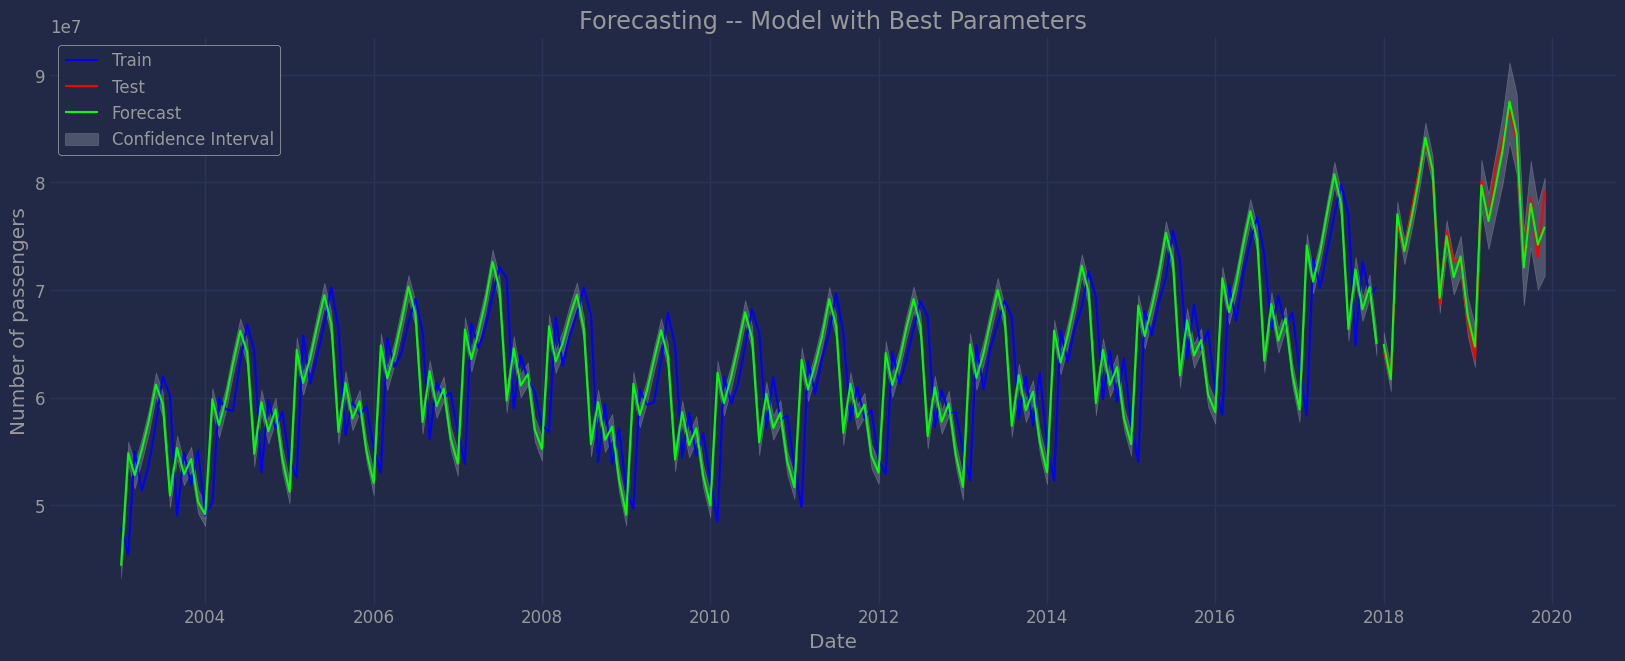

In [27]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=train, x="ds", y="y", label="Train", color="blue")
sns.lineplot(data=test, x="ds", y="y", label="Test", color="red")
sns.lineplot(data=train, x="ds", y="yhat2", label="Forecast", color="lime")
sns.lineplot(data=test, x="ds", y="yhat2", color="lime")
plt.fill_between(
    train["ds"], train["yhat2_lower"], train["yhat2_upper"], color="white", alpha=0.2
)
plt.fill_between(
    test["ds"],
    test["yhat2_lower"],
    test["yhat2_upper"],
    color="white",
    alpha=0.2,
    label="Confidence Interval",
)

plt.title("Forecasting -- Model with Best Parameters")
plt.xlabel("Date")
plt.ylabel("Number of passengers")
plt.grid(True)
plt.legend()
plt.show()

Plot of the predictions on test set with the best parameters model.

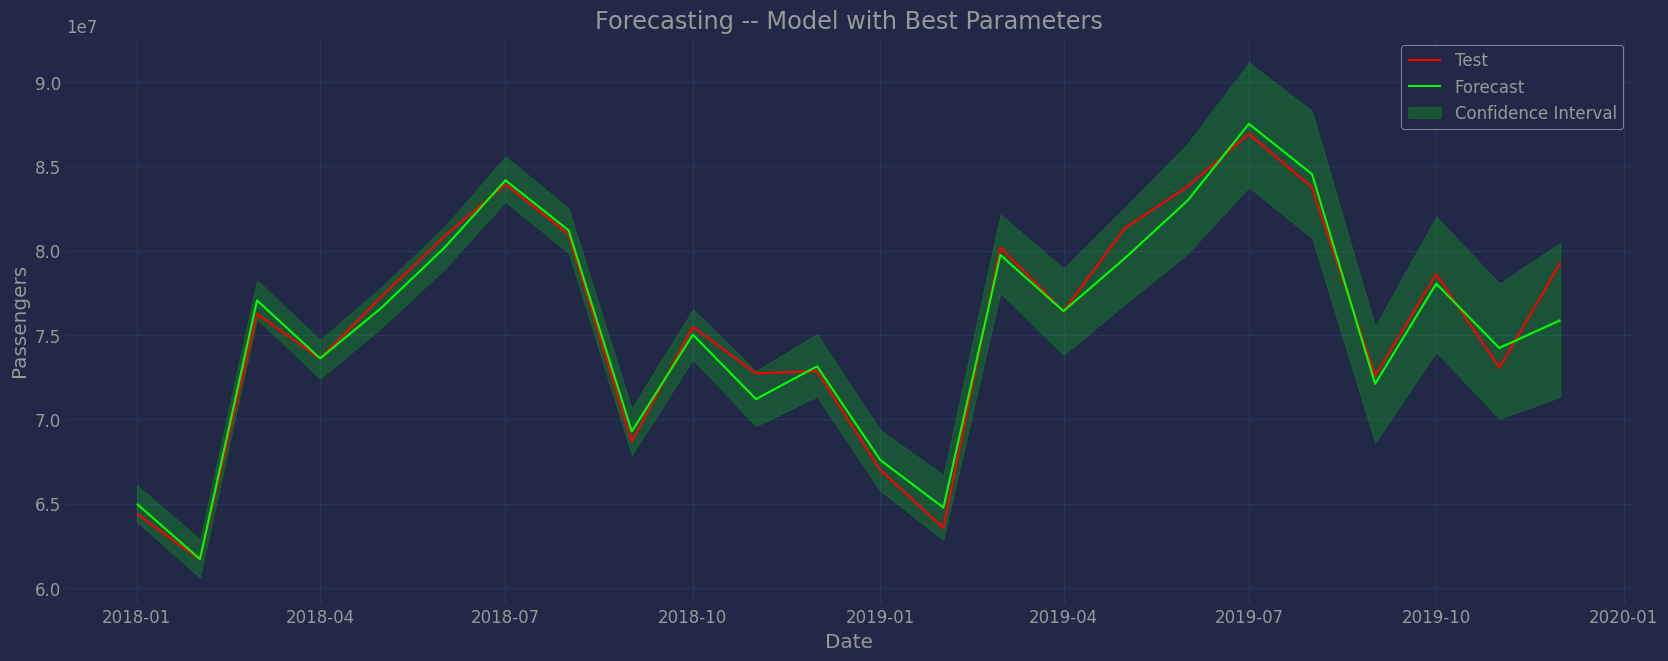

In [28]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=test, x="ds", y="y", label="Test", color="red")
sns.lineplot(data=test, x="ds", y="yhat2", label="Forecast", color="lime")
plt.fill_between(
    test["ds"],
    test["yhat2_lower"],
    test["yhat2_upper"],
    color="lime",
    alpha=0.2,
    label="Confidence Interval",
)

plt.title("Forecasting -- Model with Best Parameters")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.grid(True)
plt.legend()
plt.savefig(
    "../graphics/Prophet_sin_covid/predictions_on_test_set_best_params.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

Plot of the trend of the best model with changepoints

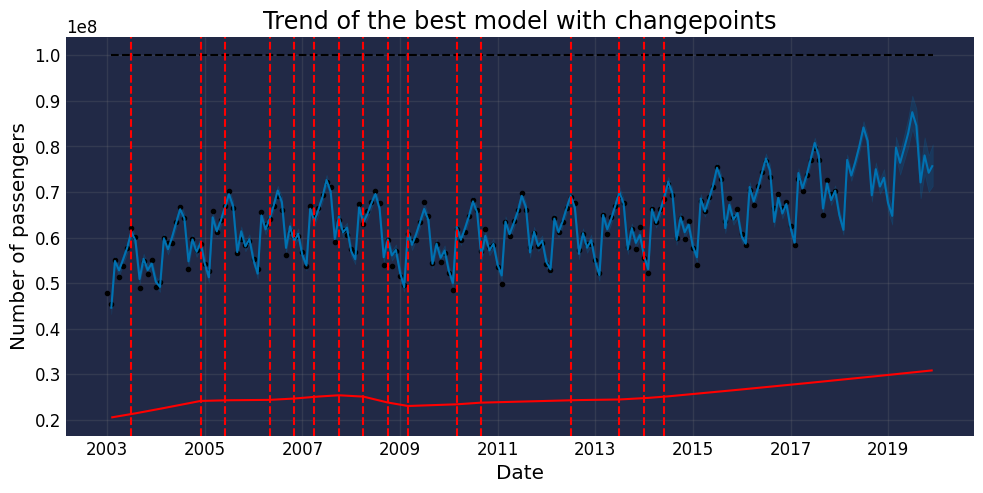

In [29]:
fig = model_best.plot(forecast_best, figsize=(10, 5))
a = add_changepoints_to_plot(fig.gca(), model_best, forecast_best)

plt.title("Trend of the best model with changepoints", color="black")
plt.xlabel("Date", color="black")
plt.ylabel("Number of passengers", color="black")
plt.tick_params(axis="both", colors="black")
plt.savefig(
    "../graphics/Prophet_sin_covid/changepoints.png", dpi=300, bbox_inches="tight"
)

### Predictions with the best model from January-2020 to December-2020 (12 months)

In [30]:
# Rename columns of df1
df1 = df1.rename(columns={
    "Date": "ds",
    "Pax": "y"
})

In [31]:
df1["cap"] = 1.0e8  # For example, set a capacity of 100 million

In [32]:
model_final = Prophet(**best_parameters)
model_final.fit(df1)

future = model_final.make_future_dataframe(periods=12, freq="ME")
future["ds"] = future["ds"] + pd.offsets.MonthBegin()
future["cap"] = train["cap"].iloc[-1]
forecast_final = model_final.predict(future)

14:14:56 - cmdstanpy - INFO - Chain [1] start processing
14:14:56 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
forecast_final

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2003-02-01,1.941865e+07,100000000.0,4.324955e+07,4.541443e+07,1.941865e+07,1.941865e+07,1.286218,1.286218,1.286218,1.286218,1.286218,1.286218,0.0,0.0,0.0,4.439527e+07
1,2003-03-01,1.954696e+07,100000000.0,5.373987e+07,5.613514e+07,1.954696e+07,1.954696e+07,1.809275,1.809275,1.809275,1.809275,1.809275,1.809275,0.0,0.0,0.0,5.491279e+07
2,2003-04-01,1.968976e+07,100000000.0,5.160965e+07,5.385936e+07,1.968976e+07,1.968976e+07,1.681150,1.681150,1.681150,1.681150,1.681150,1.681150,0.0,0.0,0.0,5.279119e+07
3,2003-05-01,1.982870e+07,100000000.0,5.431094e+07,5.672000e+07,1.982870e+07,1.982870e+07,1.798623,1.798623,1.798623,1.798623,1.798623,1.798623,0.0,0.0,0.0,5.549305e+07
4,2003-06-01,1.997304e+07,100000000.0,5.688990e+07,5.921258e+07,1.997304e+07,1.997304e+07,1.904056,1.904056,1.904056,1.904056,1.904056,1.904056,0.0,0.0,0.0,5.800284e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2020-08-01,2.995459e+07,100000000.0,8.561852e+07,8.830008e+07,2.977068e+07,3.013001e+07,1.901546,1.901546,1.901546,1.901546,1.901546,1.901546,0.0,0.0,0.0,8.691462e+07
212,2020-09-01,3.004759e+07,100000000.0,7.243172e+07,7.513378e+07,2.981468e+07,3.028249e+07,1.455882,1.455882,1.455882,1.455882,1.455882,1.455882,0.0,0.0,0.0,7.379332e+07
213,2020-10-01,3.013775e+07,100000000.0,7.854190e+07,8.146157e+07,2.983483e+07,3.043744e+07,1.654169,1.654169,1.654169,1.654169,1.654169,1.654169,0.0,0.0,0.0,7.999068e+07
214,2020-11-01,3.023108e+07,100000000.0,7.463506e+07,7.757515e+07,2.986103e+07,3.059887e+07,1.518205,1.518205,1.518205,1.518205,1.518205,1.518205,0.0,0.0,0.0,7.612806e+07


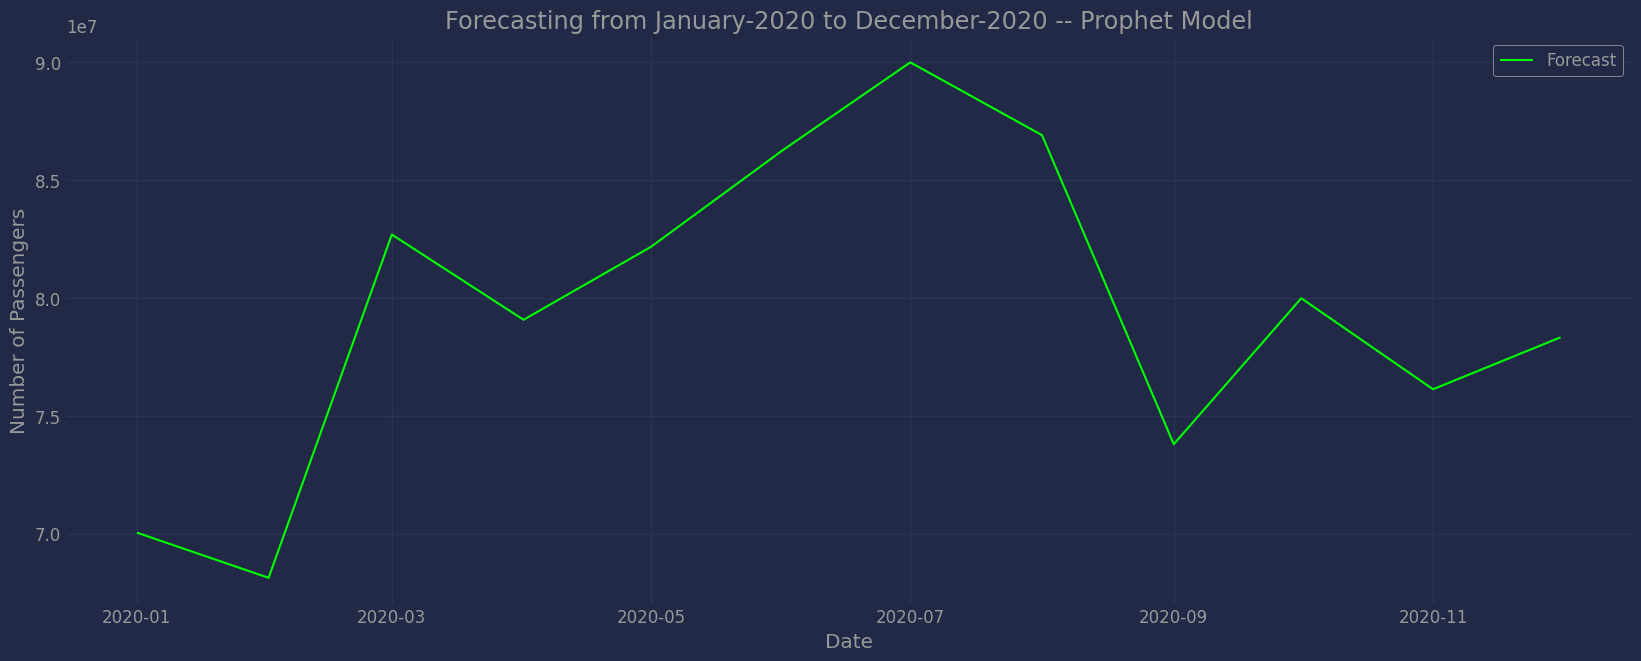

In [34]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=forecast_final.tail(12), x="ds", y="yhat", label="Forecast", color="lime")
plt.title("Forecasting from January-2020 to December-2020 -- Prophet Model")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.grid(True)
plt.legend()
plt.savefig("../graphics/Prophet_sin_covid/final_pred_prophet.png", dpi=300, bbox_inches="tight")
plt.show()